# Keras Baseline Engine for VAS Challenge 2019

## Imports

In [1]:
import os
import sys
import glob
import tqdm
import keras
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
import tensorflow as tf
from matplotlib import patches
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
import gc

# Local file import
import DftSpectrogram
import Metrics

config = tf.ConfigProto()
config.gpu_options.allow_growth = False
sess = tf.Session(config=config)
tf.logging.set_verbosity(tf.logging.ERROR)

print("Done!")
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Done!


## Path to train dataset dir

In [2]:
dataset_dir = "/home/ilya/Documents/kaggle/audio/"
train_dataset_dir = os.path.join(dataset_dir, "Training_Data/")

!tree {train_dataset_dir} -L 1

/home/ilya/Documents/kaggle/audio/Training_Data/
├── human
└── spoof

2 directories, 0 files


## File paths

In [3]:
wav_paths = sorted(glob.glob(os.path.join(train_dataset_dir, '**/*.wav'), recursive=True))
random.shuffle(wav_paths)

train_paths = wav_paths[:1000]
dev_paths = wav_paths[10000:11000]

train_human  = sorted(filter(lambda path: "human" in path, train_paths))
train_spoof = sorted(filter(lambda path: "spoof" in path, train_paths))
dev_human  = sorted(filter(lambda path: "human" in path, dev_paths))
dev_spoof = sorted(filter(lambda path: "spoof" in path, dev_paths))

print("Train Human: %d" % len(train_human))
print("Train Spoof: %d" % len(train_spoof))
print("Dev   Human: %d" % len(dev_human))
print("Dev   Spoof: %d" % len(dev_spoof))

Train Human: 184
Train Spoof: 816
Dev   Human: 214
Dev   Spoof: 786


## Raw Feature Extractor 

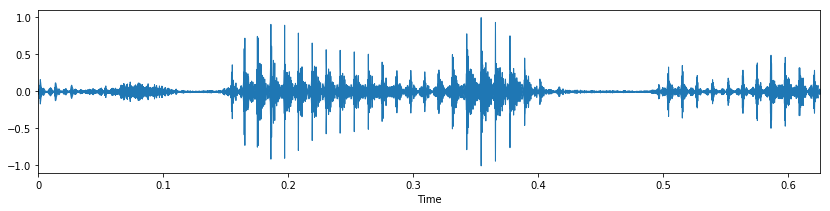

(10000,)


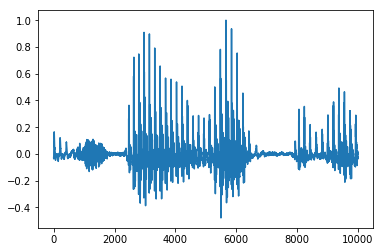

In [4]:
def get_feature(wav_path, length=66000, random_start=False):
    try:
        x, sr = librosa.load(wav_path, sr=None)
        assert sr == 16000
        if length > len(x):
            x = np.concatenate([x] * int(np.ceil(length/len(x))))
        if random_start:
            x = x[random.randint(0, len(x) - length):]
        feature = x[:length]
        return feature / np.max(np.abs(feature))
    except Exception as e:
        print("Error with getting feature from %s: %s" % (wav_path, str(e)))
        return None

feature = get_feature(random.choice(train_human), length=10000, random_start=True)
plt.figure(figsize=(14, 3))
librosa.display.waveplot(feature, sr=16000)
plt.show()
plt.plot(feature)
print(feature.shape)

In [5]:
feature.std()

0.09674561

## Train Data Generator

In [6]:
import pywt

In [7]:
dt = 0.25  # 4 Hz sampling
frequencies = pywt.scale2frequency('cmor1.0-0.5', feature) / dt
print(frequencies)

[-73.10844  -55.669724 -54.178574 ... -57.24528  -65.95652  -89.2353  ]


In [8]:
coefficients, frequencies = pywt.cwt(feature,13,'cmor')

In [9]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

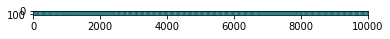

In [10]:
scales = range(1,129)
waveletname = 'fbsp'
train_size = 5000
test_size= 500 

# skimage.measure.block_reduce(feature, (200,), np.std)
coeff, freq = pywt.cwt(feature, scales, waveletname, 1)

plt.imshow(coeff.astype('float'))

In [11]:
coeff.shape

(128, 10000)

In [12]:
import skimage.measure

62
(16, 64, 167, 1)
(16, 2)


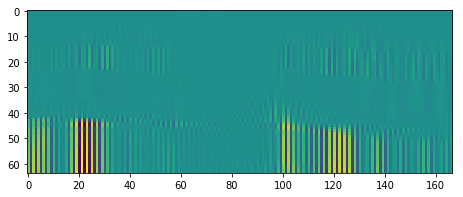

In [96]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, human_paths, spoof_paths, feature_extractor,wavelet='shan',
                 batch_size=16, amin=0.01,ref=np.max,n_fft=700):
        self.human_paths = human_paths
        self.spoof_paths = spoof_paths
        self.batch_size = batch_size
        self.feature_extractor = feature_extractor
        self.n_samples = len(self.human_paths) + len(self.spoof_paths)
        self.on_epoch_end()
        self.n_fft = n_fft
        self.amin = amin
        self.ref = ref
        self.wavelet = wavelet
        
    def __len__(self):
        return int(np.floor(self.n_samples / self.batch_size))
    
    def __getitem__(self, index):
        return self.data_generation()
        
    def on_epoch_end(self):
        random.shuffle(self.human_paths)
        random.shuffle(self.spoof_paths)
        
    def __spec_builder(self,wav):
        scales = range(1,129)
        waveletname = self.wavelet    
        coeff, freq = pywt.cwt(wav, scales, waveletname, 1)

        return skimage.measure.block_reduce(coeff.astype('float'), (2,60), np.mean) 
    
    def data_generation(self):
        wavs, labels = [], []
        while len(wavs) < self.batch_size // 2:
            wav = self.feature_extractor(random.choice(self.human_paths))
            wav = self.__spec_builder(wav)
            if wav is not None:
                wavs.append(wav)
                labels.append(0)
        while len(wavs) < self.batch_size:
            wav = self.feature_extractor(random.choice(self.spoof_paths))
            wav = self.__spec_builder(wav)
            if wav is not None:
                wavs.append(wav)
                labels.append(1)

        return np.stack(wavs, 0)[..., np.newaxis], keras.utils.to_categorical(np.stack(labels, 0), num_classes=2)

train_get_feature = lambda path: get_feature(path, length=10000, random_start=True)
train_data_generator = DataGenerator(train_human, train_spoof, train_get_feature, batch_size=16)
features, labels = train_data_generator[0]
plt.figure(figsize=(14, 3))
plt.imshow(features[0, ..., 0])
print(len(train_data_generator))
print(features.shape)
print(labels.shape)

## Dev Data Generator

1000
(1, 64, 167, 1)
(1, 2)
-5.991667556962732e-05


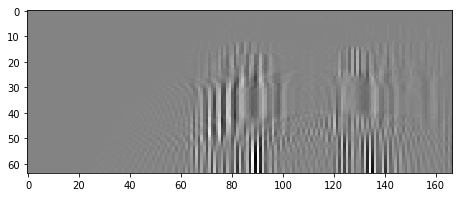

In [95]:
class DevDataGenerator(keras.utils.Sequence):
    def __init__(self, human_paths, spoof_paths, feature_extractor,wavelet='shan',amin=0.0001,ref=np.max,n_fft=700):
        self.human_paths = human_paths
        self.spoof_paths = spoof_paths
        self.paths = human_paths + spoof_paths
        self.labels = [0] * len(human_paths) + [1] * len(spoof_paths)
        self.feature_extractor = feature_extractor
        self.n_fft = n_fft
        self.amin = amin
        self.ref = ref
        self.wavelet = wavelet
        
    def __len__(self):
        return len(self.paths)
    
    def __spec_builder(self,wav):
        scales = range(1,129)
        waveletname = self.wavelet     
        coeff, freq = pywt.cwt(wav, scales, waveletname, 1)

        return skimage.measure.block_reduce(coeff.astype('float'), (2,60), np.mean) 
    
    def __getitem__(self, index):
        feature = self.feature_extractor(self.paths[index])
        spec = self.__spec_builder(feature)[np.newaxis, ...]
        return spec[..., np.newaxis], keras.utils.to_categorical([self.labels[index]], num_classes=2)
        
dev_get_feature = lambda path: get_feature(path, length=10000, random_start=False)
dev_data_generator = DevDataGenerator(dev_human, dev_spoof, dev_get_feature)
features, labels = dev_data_generator[7]
plt.figure(figsize=(14, 3))
plt.imshow(features[0, ..., 0],cmap='gray')
print(len(dev_data_generator))
print(features.shape)
print(labels.shape)
print(features.mean())

## Feature Extractor Layer

In [17]:
from matplotlib.pyplot import figure

spectrogram shape: [256, None, 1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
dft_spectrogram_1 (DftSpectr (None, 256, None, 1)      0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
(1, 256, 38, 1)


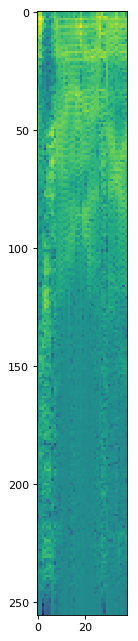

In [18]:
dft_conf = {"length": 512,
            "shift": 256,
            "nfft": 512,
            "mode": 'log',
            "normalize_feature": True}

inputs = keras.layers.Input(shape=(None, 1))
outputs = DftSpectrogram.DftSpectrogram(**dft_conf)(inputs)
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

result = model.predict(feature[np.newaxis, ..., np.newaxis])
print(result.shape)
figure(num=None, figsize=(40, 10), dpi=80,)
imgplot = plt.imshow(result[0, :, : ,0])

## Build Model

In [97]:
from keras.models import Sequential, Model
from keras.layers import (Conv2D,MaxPooling2D,Dropout,Dense,BatchNormalization,Input,Flatten, Reshape,
                          AveragePooling2D,Conv1D,Concatenate,LSTM,ConvLSTM2D)
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler

In [98]:
def create_model(shape):
    Model_input = Input(shape=shape)
    m_pooling = MaxPooling2D((1,2))(Model_input)
    conv = Conv2D(50, kernel_size=(2,3), activation='relu')(m_pooling)
    b_n = BatchNormalization()(conv)
    drop = Dropout(0.1)(b_n)
    conv = Conv2D(50, kernel_size=(2,4), activation='relu')(drop)
    m_pooling = MaxPooling2D((2,3))(conv)
    b_n = BatchNormalization()(m_pooling)
    drop = Dropout(0.1)(b_n)
    conv = Conv2D(50, kernel_size=(4,5), activation='relu')(drop)
    m_pooling = MaxPooling2D((2,2))(conv)
    b_n = BatchNormalization()(m_pooling)
    conv = Conv2D(50, kernel_size=(4,4), activation='relu')(b_n)
    m_pooling = MaxPooling2D((2,2))(conv)
    conv = Conv2D(50, kernel_size=(2,2), activation='relu')(m_pooling)
    out = Conv2D(2, kernel_size=(1,1), activation='softmax')(conv)
    out = Reshape((-1,))(out)
    out = Dense(2, activation='softmax')(out)
    model = Model(inputs=Model_input, outputs=out)
#     model.summary()
    return model


model = create_model((64, 167,1))


## Callbacks

In [99]:
def exp_decay(epoch, k=0.2, initial_rate=0.01):
    return initial_rate * np.exp(-k * (epoch+5))

class Saver(keras.callbacks.Callback):
    def __init__(self, temp_models_dir):
        super().__init__()
        self.temp_models_dir = temp_models_dir
    def on_train_begin(self, logs={}):
        !mkdir -p {self.temp_models_dir}
        !rm {self.temp_models_dir}/*
    def on_epoch_end(self, epoch, logs={}):
        model.save("%s/model_epoch_%d.h5" % (self.temp_models_dir, epoch + 1))
        
class Eer(keras.callbacks.Callback):
    def __init__(self, dev_data_generator):
        super().__init__()
        self.dev_data_generator = dev_data_generator
        self.val_eers = None
    def on_train_begin(self, logs={}):
        self.val_eers = []
    def on_epoch_end(self, epoch, logs):
        results = model.predict_generator(self.dev_data_generator, verbose=1)
        human = results[:len(self.dev_data_generator.human_paths), 0]
        spoof = results[len(self.dev_data_generator.human_paths):, 0]
        val_eer = Metrics.compute_err(human, spoof)[0]
        self.val_eers.append(val_eer)
        logs["val_eer"] = val_eer
        print("%sEER = %0.3f%%" % (" "*20, val_eer))

learning_rate   = keras.callbacks.LearningRateScheduler(exp_decay)
saver           = Saver("./temp_models/")
eer             = Eer(dev_data_generator)
        
callbacks     = [learning_rate, saver, eer]
print("Total %d callbacks" % len(callbacks))

Total 3 callbacks


In [100]:
list_w = ['cgau1','cgau3','cgau5','cgau7','cmor','cmor1-1','cmor1-4',
'fbsp','gaus1','gaus3','gaus5','gaus7','mexh','morl','shan','shan1-5']

## Train Model

In [101]:
for i in ['gaus5']:
    print(i)
    dev_data_generator = DevDataGenerator(dev_human, dev_spoof, dev_get_feature,wavelet=i)
    train_data_generator = DataGenerator(train_human, train_spoof, train_get_feature, batch_size=4,wavelet=i)

    model = create_model((64, 167,1))
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-5, decay=0),
                      metrics=['accuracy'])

    eer = Eer(dev_data_generator)
#     callbacks = [learning_rate, saver, eer]
    model.fit_generator(train_data_generator,
                                    steps_per_epoch = None,
                                    epochs = 1,
#                                     callbacks = callbacks,
                                    use_multiprocessing = True,
                                    workers = 8,
                                    )

cmor
Epoch 1/1
250/250 [==============================] - 238s 951ms/step - loss: 0.7228 - acc: 0.5000


In [ ]:
cmor  gaus5

## Load best checkpoint

In [46]:
best_checkpoint = np.argmin(eer.val_eers)
print("Best checkpoint - Epoch %d: EER = %0.3f%%" % (best_checkpoint + 1, eer.val_eers[best_checkpoint]))

model.load_weights("./temp_models/model_epoch_%d.h5" % (best_checkpoint + 1))
print("Done!")

Best checkpoint - Epoch 2: EER = 1.358%
Done!


## Save model

In [48]:
# model.save("./models/baseline_model.h5")
# print("Done!")

## Check single files

In [50]:
print(model.predict(dev_get_feature(random.choice(dev_human))[np.newaxis, ..., np.newaxis])[0][0])
print(model.predict(dev_get_feature(random.choice(dev_spoof))[np.newaxis, ..., np.newaxis])[0][0])

## Run dev generator

In [18]:
results = model.predict_generator(dev_data_generator, verbose=1, steps=None)
print(len(results))
print(results[:5])

10000/10000 [==============================] - 41s 4ms/step
10000
[[9.9996829e-01 3.1705771e-05]
 [1.0000000e+00 2.7587401e-08]
 [9.9997389e-01 2.6144800e-05]
 [9.9999964e-01 4.1709922e-07]
 [9.9998868e-01 1.1340149e-05]]


## Metrics

2021
7979

EER = 0.735 %   @  0.939


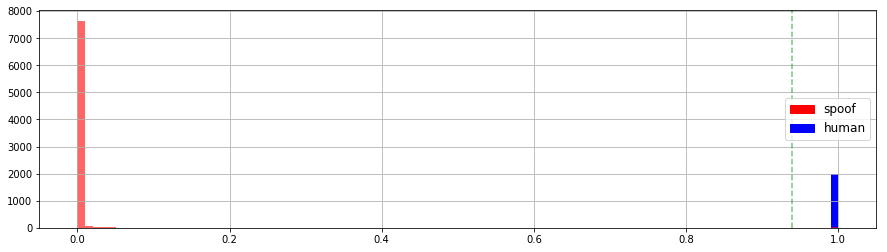

In [22]:
human = results[:len(dev_data_generator.human_paths), 0]
spoof = results[len(dev_data_generator.human_paths):, 0]

print(len(human))
print(len(spoof))

eer, threshold = Metrics.compute_err(human, spoof)

print("\nEER = %0.3f %%   @  %0.3f" % (eer, threshold))

plt.figure(figsize=(15, 4))
plt.hist(human, 99, facecolor='b', alpha=1)
plt.hist(spoof, 99, facecolor='r', alpha=0.6)
red_patch = patches.Patch(color='red', label='spoof')
blue_patch = patches.Patch(color='blue', label='human')
plt.axvline(x=threshold, linestyle='--', color='g', alpha=0.5)
plt.legend(handles=[red_patch, blue_patch], loc=5, fontsize=12)
plt.grid(True)
plt.show()

# Keras Baseline Engine for VAS Challenge 2019

In [3]:
DftSpectrogram

<module 'DftSpectrogram' from '/home/ilya/Documents/kaggle/audio/idrnd_antispoof_Baseline ID R&D/Baseline ID R&D/DftSpectrogram.py'>